# Imports

In [7]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import ray

ray.init(dashboard_port=1111, ignore_reinit_error=True)

2021-05-24 22:08:35,013	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:6379',
 'object_store_address': '/tmp/ray/session_2021-05-24_22-08-32_008843_66703/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-24_22-08-32_008843_66703/sockets/raylet',
 'webui_url': '127.0.0.1:1111',
 'session_dir': '/tmp/ray/session_2021-05-24_22-08-32_008843_66703',
 'metrics_export_port': 60572,
 'node_id': 'c8419dc626e8ea0e06b7a1f399f1746c731f2df8a9474c62a18dfe43'}

In [57]:
# ray.shutdown()

# Sample tick dates

In [41]:
from data_model import arrow_dataset, s3_backend
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, stacked, labels, meta, meta_ray


thresh = {
    # meta params
    'symbol': 'MAG',
    'start_date': '2020-11-10',
    'end_date': '2020-11-16',
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 17,  # 11
    'mad_diff': 'simple',
    'jma_winlen': 7,
    'jma_power': 2,
    # time batcher
    'batch_freq': '2s',
    # bar sampler params
    'renko_return': 'price_jma_return',
    'renko_size': 0.1,  # for simple runs
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'renko_range_min_pct_value': 0.03,  # X% of symbol value to enforc min renko size
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [37]:
symbs = s3_backend.list_symbols('trades')
symbs

['AEM',
 'AG',
 'AGI',
 'ASA',
 'AU',
 'AUY',
 'AXU',
 'BTG',
 'BVN',
 'CDE',
 'DRD',
 'EGO',
 'EXK',
 'FNV',
 'FSM',
 'GFI',
 'GLD',
 'GORO',
 'GSS',
 'HL',
 'HMY',
 'IAG',
 'KGC',
 'KL',
 'MAG',
 'MUX',
 'NEM',
 'NG',
 'OR',
 'PAAS',
 'PVG',
 'RGLD',
 'SA',
 'SAND',
 'SSRM',
 'SVM',
 'USAS',
 'VTI',
 'WPM']

In [42]:
# bd = meta.sample_date(thresh, date='2020-01-13')

bds = meta_ray.sample_dates(thresh)

(pid=66722) MAG 2020-11-11 trying to get data from local file...
(pid=66721) MAG 2020-11-12 trying to get data from local file...
(pid=66723) MAG 2020-11-13 trying to get data from local file...
(pid=66724) MAG 2020-11-16 trying to get data from local file...


(pid=66721) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:18: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=66721)   tick_filter.update(
(pid=66722) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:18: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=66722)   tick_filter.update(
(pid=66723) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:18: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=66723)   tick_filter.update(
(pid=66724) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:18: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=66724)   tick_filter.update(


In [96]:
bds[0].keys()

dict_keys(['symbol', 'date', 'thresh', 'ticks_df', 'bars_df', 'bars'])

<AxesSubplot:>

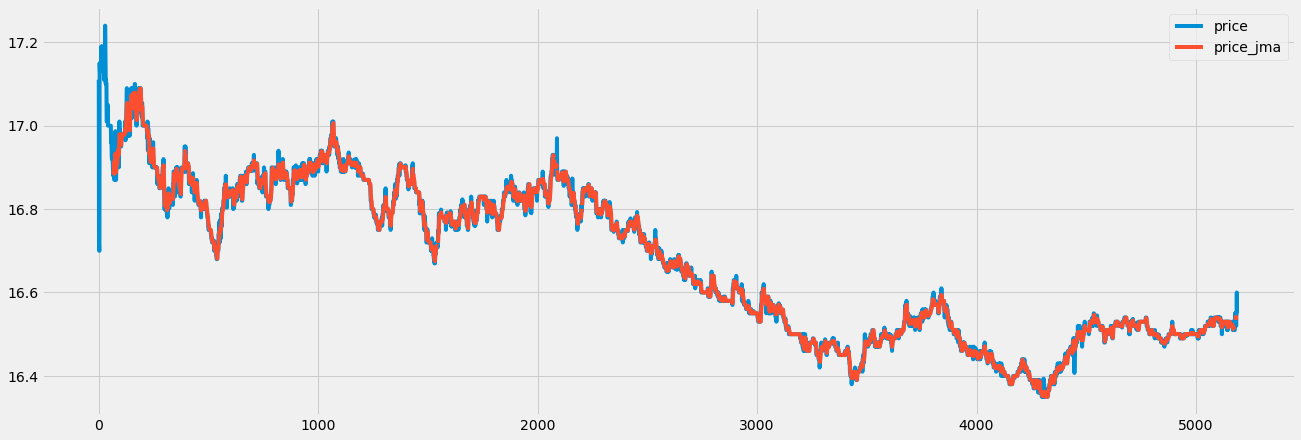

In [84]:
n = 3

bds[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:xlabel='nyc_dt'>

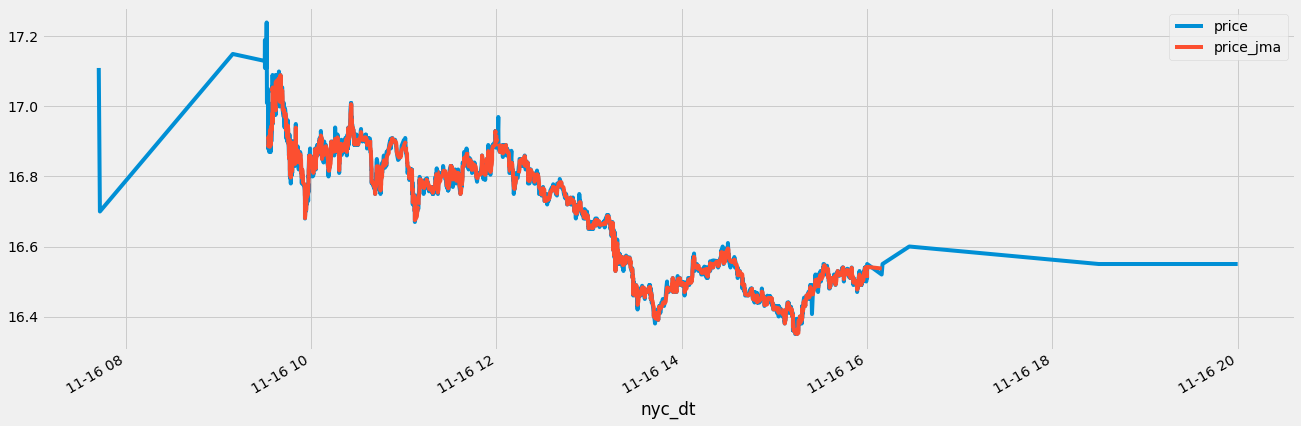

In [85]:
bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot()

<AxesSubplot:xlabel='nyc_dt'>

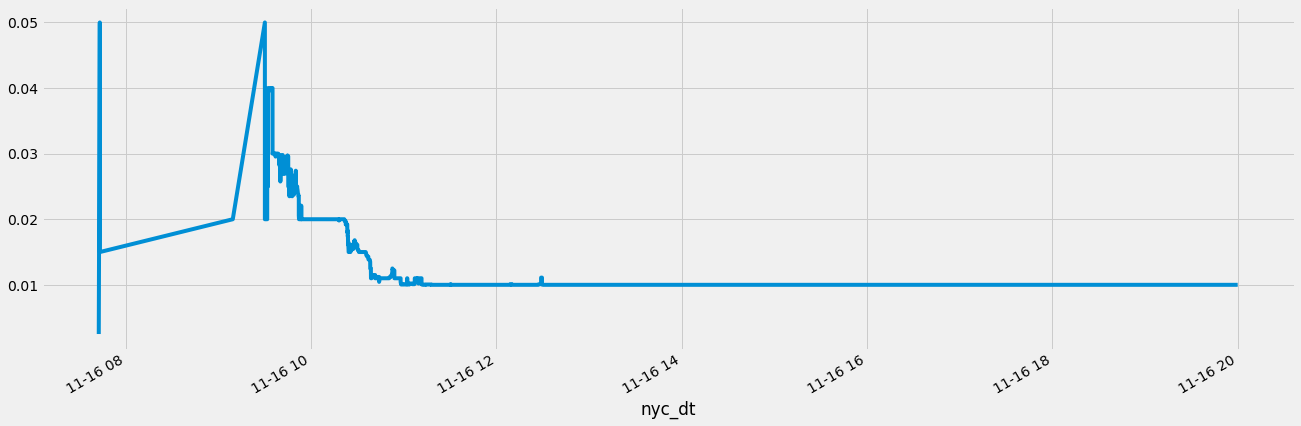

In [86]:
bds[n]['ticks_df'].set_index('nyc_dt')['mad'].plot()

<AxesSubplot:>

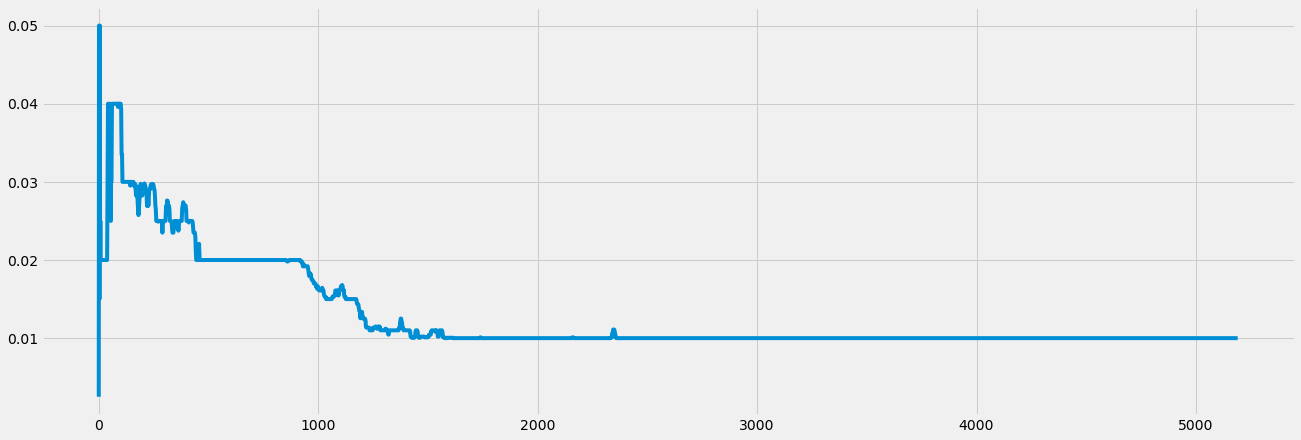

In [87]:
bds[n]['ticks_df']['mad'].plot()

In [88]:
pd.DataFrame(abs(bds[n]['bars_df'].label_rrr)).value_counts() / len(bds[n]['bars_df'])

label_rrr
0.000000    0.187500
2.000000    0.187500
3.000000    0.125000
2.500000    0.104167
4.000000    0.104167
3.500000    0.062500
4.500000    0.062500
5.000000    0.062500
5.500000    0.041667
6.500000    0.041667
6.000000    0.020833
dtype: float64

<AxesSubplot:>

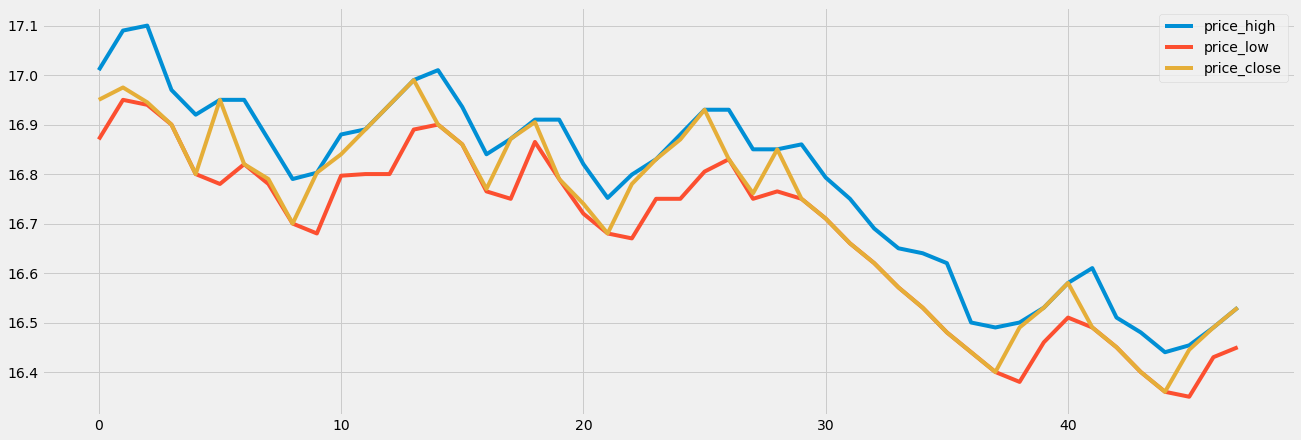

In [89]:
bds[n]['bars_df'][['price_high', 'price_low', 'price_close']].plot()

In [50]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

,date,bar_count,duration_min_median,price_range_mean,first_bar_open,last_bar_close
0,2020-11-11,27,8.366667,0.138211,2020-11-11 09:30:18.234255872-05:00,2020-11-11 15:29:54.260560384-05:00
1,2020-11-12,29,8.683333,0.122045,2020-11-12 09:34:28.115668480-05:00,2020-11-12 15:27:56.792468224-05:00
2,2020-11-13,20,10.650000,0.099445,2020-11-13 09:33:35.867800832-05:00,2020-11-13 15:37:05.350338560-05:00
3,2020-11-16,48,5.125000,0.099788,2020-11-16 09:32:11.821960192-05:00,2020-11-16 15:31:21.834511104-05:00


In [51]:
stats_df.describe()

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

,bar_count,duration_min_median,price_range_mean
count,4.000000,4.000000,4.000000
mean,31.000000,8.206250,0.114872
std,11.972190,2.289058,0.018812
min,20.000000,5.125000,0.099445
25%,25.250000,7.556250,0.099702
50%,28.000000,8.525000,0.110916
75%,33.750000,9.175000,0.126087
max,48.000000,10.650000,0.138211


In [52]:
results = []

for date in bds:
    bars_df = date['bars_df'].copy()
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    rrr = (abs(bars_df.label_rrr).value_counts() / bars_df.shape[0]).to_dict()    
    out.update(rrr)
    results.append(out)

pd.DataFrame(results)

,clean: market-open,filtered: mad_warmup,filtered: irregular condition,clean: after-hours,filtered: zero volume,filtered: ts diff,date,0.0,4.0,3.5,3.0,2.5,5.5,2.0,4.5,6.5,filtered: mad_outlier,5.0,6.0
0,0.980323,0.013266,0.003095,0.001990,0.000663,0.000663,2020-11-11,0.518519,0.148148,0.111111,0.074074,0.074074,0.037037,0.037037,NaN,NaN,NaN,NaN,NaN
1,0.972119,0.016463,0.009294,0.001328,0.000797,NaN,2020-11-12,0.482759,0.034483,0.034483,0.137931,0.068966,NaN,0.137931,0.068966,0.034483,NaN,NaN,NaN
2,0.961262,0.020569,0.008913,0.006856,0.001028,0.001028,2020-11-13,0.550000,0.050000,NaN,0.100000,0.100000,NaN,0.100000,0.050000,NaN,0.000343,0.050000,NaN
3,0.981121,0.011944,0.005394,0.000963,0.000578,NaN,2020-11-16,0.187500,0.104167,0.062500,0.125000,0.104167,0.041667,0.187500,0.062500,0.041667,NaN,0.062500,0.020833
